<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import random
from collections import Counter
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint


### Algoritmos

In [2]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    X_columns = dataframe.columns[dataframe.columns != 'Classe']
    X = dataframe[X_columns]
    Y = dataframe['Classe']

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [3]:
def BlockSplit0(dataframe, n_splits, seed, n_songs):

  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  test_list = []
  definitive_test_list = []


  for i in range(10):
    r = random.sample(range(i*songs_per_genre, (i+1)*songs_per_genre), n_test)
    for j in r:
      test_list.append(j)

  test_list.sort()
  for i in test_list:
    for j in range(n_block):
      definitive_test_list.append(round((i*n_block)+j))

  return definitive_test_list

In [4]:
def BlockSplit(dataframe, seed, n_songs):


  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  #used_list = []
  range_list = []
  block_lists = []

  for i in range(10):
    range_list.append(range(i*songs_per_genre, (i+1)*songs_per_genre))

  for k in range(10):
    test_list = []
    definitive_test_list = []

    for i in range(10):
      r = random.sample(range_list[i], n_test)
      #print(range_list[i])
      range_list[i] = [element for element in range_list[i] if element not in r]

      for j in r:
        test_list.append(j)

    test_list.sort()
    #print(test_list)
    for i in test_list:
      for j in range(n_block):
        definitive_test_list.append(round((i*n_block)+j))

    #print(definitive_test_list)
    block_lists.append(definitive_test_list)

  return block_lists

In [5]:
def blockBalancedScore(Y_real, Y_predict, n_songs):

  #print(type(Y_real))

  n_samples = len(Y_predict)
  samples_per_song = (n_samples*10)/n_songs

  block_predict = []
  block_true = []

  # print('N_songs:', n_songs)
  # print('N_samples:', len(Y_predict))
  # print('samples_per_song:', samples_per_song)

  predict_groups = [Y_predict[i:i+int(samples_per_song)] for i in range(0, n_samples, int(samples_per_song))]

  for group in predict_groups:
    count = Counter(group)
    block_predict.append(count.most_common(1)[0][0])

  indexes = range(0, n_samples, int(samples_per_song))
  block_true = Y_real.iloc[indexes].tolist()

  return balanced_accuracy_score(block_true, block_predict)

In [24]:
def tuningKNN(df, seeds, n_songs):

  n_neigh = [1, 3, 5, 7, 9]
  weights = ['uniform', 'distance']
  algorithm = ['ball_tree', 'kd_tree', 'brute']
  leaf_size = [10, 30, 50, 70, 90]
  p = [1, 2]

  result = pd.DataFrame(columns=['score ind', 'score bloco', 'n_neigh', 'weights', 'algorithm', 'leaf_size', 'p'])

  for n in n_neigh:
    for w in weights:
      for a in algorithm:
        for l in leaf_size:
          for p_ in p:


            scorelistKNN = []
            scorelistKNNB = []
            for seed in seeds:

              scorelistKNN_t = []
              scorelistKNNB_t = []

              df['Classe'] = pd.Categorical(df['Classe'])
              df['Classe'] = df['Classe'].cat.codes

              neigh = neighbors.KNeighborsClassifier(n_neighbors=n, weights=w, algorithm=a, leaf_size=l, p=p_)

              test_list = BlockSplit(df, seed = seed, n_songs=n_songs)

              scaler = MinMaxScaler()
              target = 'Classe'
              X_columns = df.columns[df.columns != target]
              X = df[X_columns]
              X = pd.DataFrame(scaler.fit_transform(X.loc[:,:]), columns=X.columns)
              Y = df['Classe']

              for test in test_list:

                neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
                Y_predict = neigh.predict(X.iloc[X.index.isin(test),:])

                scorelistKNN_t.append(balanced_accuracy_score(Y.iloc[test], Y_predict))
                scorelistKNNB_t.append(blockBalancedScore(Y.iloc[test], Y_predict, n_songs))

              scorelistKNN.append(np.mean(scorelistKNN_t, axis=0))
              scorelistKNNB.append(np.mean(scorelistKNNB_t, axis=0))

            new_data = [np.mean(scorelistKNN, axis=0), np.mean(scorelistKNNB, axis=0), n, w, a, l, p_]
            result.loc[len(result)] = new_data

  return result

In [ ]:
def tuningDT(df, seeds, n_songs):
  max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
  min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
  min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  max_features =
  criterion = ['gini', 'entropy']


In [59]:
def tuningDT(df, seeds, n_songs):

  param_dist = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  # Profundidade máxima da árvore
    'max_features': randint(10, 40),  # Número máximo de características
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Número mínimo de amostras em um nó folha
    'criterion': ['gini', 'entropy'],
     # Função de qualidade da divisão
    }

  df['Classe'] = pd.Categorical(df['Classe'])
  df['Classe'] = df['Classe'].cat.codes

  scaler = MinMaxScaler()
  target = 'Classe'
  X_columns = df.columns[df.columns != target]
  X = df[X_columns]
  X = pd.DataFrame(scaler.fit_transform(X.loc[:,:]), columns=X.columns)
  Y = df['Classe']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seeds)

  tree = DecisionTreeClassifier()

  random_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=200, cv=5, random_state=seeds)
  random_search.fit(X_train, y_train)

  # Melhores parâmetros encontrados
  print("Melhores parâmetros encontrados:")
  print(random_search.best_params_)

  # Avaliar o modelo com os melhores parâmetros
  print("Acurácia do modelo nos dados de teste:")
  print(random_search.score(X_test, y_test))

In [6]:
def elbowAll(dflist, seed, n_songs):
  scorelistKNN = []
  scorelistDT = []
  scorelistRF = []
  scorelistSVM = []
  scorelistXGB = []
  scorelistMLP = []
  scorelistLR = []

  scorelistKNNB = []
  scorelistDTB = []
  scorelistRFB = []
  scorelistSVMB = []
  scorelistXGBB = []
  scorelistMLPB = []
  scorelistLRB = []

  for df in dflist:


    scorelistKNN_t = []
    scorelistDT_t = []
    scorelistRF_t = []
    scorelistSVM_t = []
    scorelistXGB_t = []
    scorelistMLP_t = []
    scorelistLR_t = []

    scorelistKNNB_t = []
    scorelistDTB_t = []
    scorelistRFB_t = []
    scorelistSVMB_t = []
    scorelistXGBB_t = []
    scorelistMLPB_t = []
    scorelistLRB_t = []


    df['Classe'] = pd.Categorical(df['Classe'])
    df['Classe'] = df['Classe'].cat.codes

    neigh = neighbors.KNeighborsClassifier()
    clf = tree.DecisionTreeClassifier(random_state = seed)
    rf = ensemble.RandomForestClassifier(random_state = seed)
    svmc = svm.SVC(random_state=seed)
    xgbc = xgb.XGBClassifier(objective='multi:softprob', random_state=seed)
    mlp = MLPClassifier(random_state=seed)
    lr = LogisticRegression(random_state=seed, max_iter=300)

    test_list = BlockSplit(df, seed = seed, n_songs=n_songs)
    scaler = MinMaxScaler()

    #df = df.drop(columns=['tempo1', 'tempo2', 'tempo3'])
    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]

    X = pd.DataFrame(scaler.fit_transform(X.loc[:,:]), columns=X.columns)

    Y = df['Classe']

    for test in test_list:

      neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predict3 = neigh.predict(X.iloc[X.index.isin(test),:])

      clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictDT = clf.predict(X.iloc[X.index.isin(test),:])

      rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictRF = rf.predict(X.iloc[X.index.isin(test),:])

      svmc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictSVM = svmc.predict(X.iloc[X.index.isin(test),:])

      xgbc.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictXGB = xgbc.predict(X.iloc[X.index.isin(test),:])

      mlp.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictMLP = mlp.predict(X.iloc[X.index.isin(test),:])

      lr.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
      Y_predictLR = lr.predict(X.iloc[X.index.isin(test),:])


      scorelistKNN_t.append(balanced_accuracy_score(Y.iloc[test], Y_predict3))
      scorelistDT_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictDT))
      scorelistRF_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictRF))
      scorelistSVM_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictSVM))
      scorelistXGB_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictXGB))
      scorelistMLP_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictMLP))
      scorelistLR_t.append(balanced_accuracy_score(Y.iloc[test], Y_predictLR))

      scorelistKNNB_t.append(blockBalancedScore(Y.iloc[test], Y_predict3, n_songs))
      scorelistDTB_t.append(blockBalancedScore(Y.iloc[test], Y_predictDT, n_songs))
      scorelistRFB_t.append(blockBalancedScore(Y.iloc[test], Y_predictRF, n_songs))
      scorelistSVMB_t.append(blockBalancedScore(Y.iloc[test], Y_predictSVM, n_songs))
      scorelistXGBB_t.append(blockBalancedScore(Y.iloc[test], Y_predictXGB, n_songs))
      scorelistMLPB_t.append(blockBalancedScore(Y.iloc[test], Y_predictMLP, n_songs))
      scorelistLRB_t.append(blockBalancedScore(Y.iloc[test], Y_predictLR, n_songs))

    scorelistKNN.append(np.mean(scorelistKNN_t, axis=0))
    scorelistDT.append(np.mean(scorelistDT_t, axis=0))
    scorelistRF.append(np.mean(scorelistRF_t, axis=0))
    scorelistSVM.append(np.mean(scorelistSVM_t, axis=0))
    scorelistXGB.append(np.mean(scorelistXGB_t, axis=0))
    scorelistMLP.append(np.mean(scorelistMLP_t, axis=0))
    scorelistLR.append(np.mean(scorelistLR_t, axis=0))

    scorelistKNNB.append(np.mean(scorelistKNNB_t, axis=0))
    scorelistDTB.append(np.mean(scorelistDTB_t, axis=0))
    scorelistRFB.append(np.mean(scorelistRFB_t, axis=0))
    scorelistSVMB.append(np.mean(scorelistSVMB_t, axis=0))
    scorelistXGBB.append(np.mean(scorelistXGBB_t, axis=0))
    scorelistMLPB.append(np.mean(scorelistMLPB_t, axis=0))
    scorelistLRB.append(np.mean(scorelistLRB_t, axis=0))



  return scorelistKNN, scorelistDT, scorelistRF, scorelistSVM, scorelistXGB, scorelistMLP, scorelistLR, scorelistKNNB, scorelistDTB, scorelistRFB, scorelistSVMB, scorelistXGBB, scorelistMLPB, scorelistLRB

### Testes

In [45]:

  dir_path = 'F:/Documentos/UTFPR/IC/csvs/ft2/3s/2048.csv'
  df = pd.read_csv(dir_path, sep=',', encoding='utf-8')


In [11]:
df.head()

,Chroma mean C,Chroma sd2 C,Chroma mean C#,Chroma sd2 C#,Chroma mean D,Chroma sd2 D,Chroma mean D#,Chroma sd2 D#,Chroma mean E,Chroma sd2 E,...,MFCC17 mean,MFCC17 sd2,MFCC18 mean,MFCC18 sd2,MFCC19 mean,MFCC19 sd2,MFCC20 mean,MFCC20 sd2,tempo,Classe
0,0.443220,0.116929,0.493957,0.090730,0.530423,0.111769,0.362471,0.059003,0.366930,0.088381,...,6.636033,32.759502,-7.169274,34.095005,-3.058473,35.901240,-1.946721,31.588928,129.199219,blues
1,0.313655,0.072836,0.373641,0.082337,0.442523,0.084624,0.334208,0.061491,0.329513,0.063039,...,5.320587,46.470245,-6.949818,58.184605,2.669857,55.784626,-1.981014,40.155030,123.046875,blues
2,0.499088,0.125944,0.492935,0.111259,0.526621,0.123019,0.429196,0.092391,0.345693,0.068706,...,5.913382,24.065811,-2.474474,49.794083,4.369329,60.341130,0.928223,25.852682,123.046875,blues
3,0.437377,0.107753,0.464106,0.081459,0.464236,0.087225,0.362642,0.068650,0.375712,0.064050,...,5.416685,30.429169,-9.023584,36.059143,-1.789123,48.316597,-1.672008,22.640732,123.046875,blues
4,0.282027,0.069667,0.342922,0.069852,0.494003,0.101733,0.333867,0.057179,0.324747,0.071538,...,4.384613,28.869833,-7.393156,33.275806,1.636896,31.263004,2.227854,35.030254,123.046875,blues


In [26]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

seeds = [14, 42, 60, 87, 113, 156]

result = tuningKNN(df, seeds = seeds, n_songs=1000)


In [62]:
tuningDT(df, 14, n_songs=1000)

Melhores parâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 37, 'min_samples_leaf': 1, 'min_samples_split': 8}
Acurácia do modelo nos dados de teste:
0.621


In [32]:
result.head()

,score ind,score bloco,n_neigh,weights,algorithm,leaf_size,p
0,0.594983,0.720333,1,uniform,ball_tree,10,1
1,0.564967,0.697833,1,uniform,ball_tree,10,2
2,0.594933,0.720667,1,uniform,ball_tree,30,1
3,0.564867,0.697667,1,uniform,ball_tree,30,2
4,0.594917,0.720500,1,uniform,ball_tree,50,1


In [37]:
df = result.sort_values(by=['score ind', 'score bloco'], ascending=False)
df.head()
df.to_csv('F:/Documentos/UTFPR/IC/csvs/tuning/tuningKNN.csv', index=False)

In [38]:
df.head()

,score ind,score bloco,n_neigh,weights,algorithm,leaf_size,p
278,0.637133,0.738500,9,distance,ball_tree,90,1
290,0.637117,0.738333,9,distance,brute,10,1
292,0.637117,0.738333,9,distance,brute,30,1
294,0.637117,0.738333,9,distance,brute,50,1
296,0.637117,0.738333,9,distance,brute,70,1


In [ ]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslistB = []
scoresmeansB = []
scoressdsB = []

scoreslist.append(np.array(knnscores))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))
scoreslist.append(np.array(svmscores))
scoreslist.append(np.array(xgbscores))
scoreslist.append(np.array(mlpscores))
scoreslist.append(np.array(lrscores))


scoreslistB.append(np.array(knnscoresB))
scoreslistB.append(np.array(dtscoresB))
scoreslistB.append(np.array(rfscoresB))
scoreslistB.append(np.array(svmscoresB))
scoreslistB.append(np.array(xgbscoresB))
scoreslistB.append(np.array(mlpscoresB))
scoreslistB.append(np.array(lrscoresB))


# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

for score in scoreslistB:
  scoresmeansB.append(np.mean(score, axis=0))
  scoressdsB.append(np.std(score, axis=0))

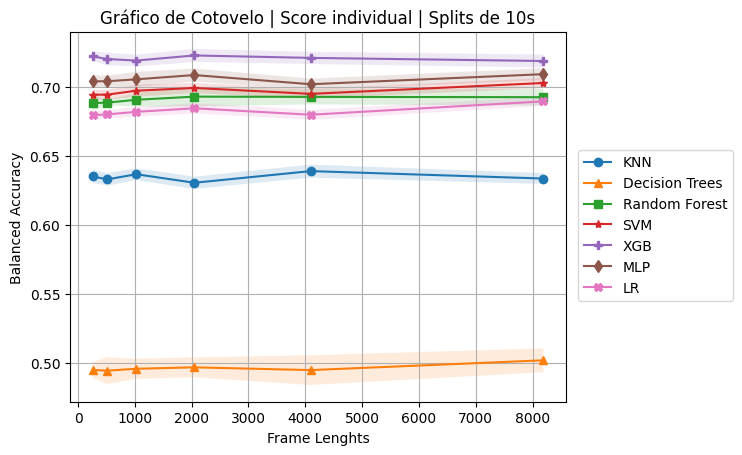

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.15)

plt.legend( bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo | Score individual | Splits de 10s')

# Nome do arquivo pra salvar
plt.savefig('F:/Documentos/UTFPR/IC/csvs/ft2/10s/score_simples_st.pdf')
plt.show()

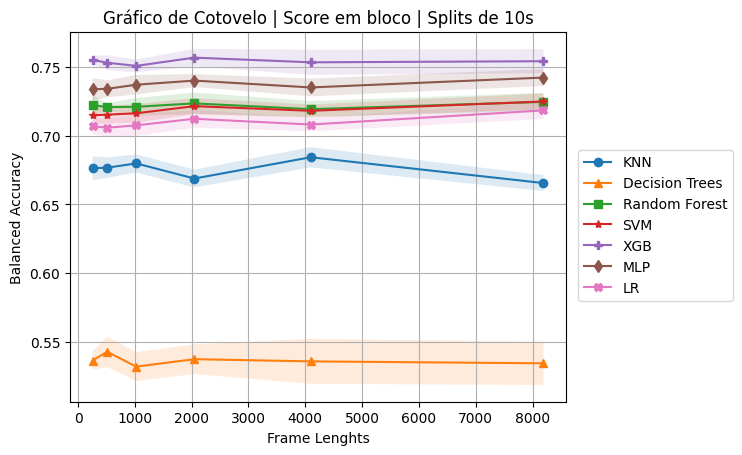

In [ ]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN', 'Decision Trees', 'Random Forest', 'SVM', 'XGB', 'MLP', 'LR']
markers = ['o', '^', 's', '*', 'P', 'd', 'X']

for i in range(len(scoresmeansB)):
  plt.plot(frame_lenghts, scoresmeansB[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeansB[i] + scoressdsB[i], scoresmeansB[i] - scoressdsB[i], alpha = 0.15)

plt.legend(bbox_to_anchor = (1.35, 0.7))
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo | Score em bloco | Splits de 10s')

# Nome do arquivo pra salvar
plt.savefig('F:/Documentos/UTFPR/IC/csvs/ft2/10s/score_bloco_st.pdf')
plt.show()